In [7]:
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torchvision import transforms, datasets

from classifiers.segmentation_nn import SegmentationNN, BinaryOut
from data_utils_SegNet import SegmentationData
from solver_SegNet import Solver
import transform_utils_NerveNet as tu
from dice_loss import DiceLoss

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define and Divide Dataset
The following calculates the **sizes of train, validation and test set**. Make sure it returns **True** by modifying the values in the dictionary 'nums'.

In [2]:
img_files = 'image_files.txt' 
num_lines = sum(1 for line in open(img_files, 'r'))
num_lines = sum(1 for line in open(img_files, 'r'))
nums = {'num_train' : int(0.6*num_lines)+2,
        'num_val'   : int(0.2*num_lines),
        'num_test' : int(0.2*num_lines)}

print(nums, num_lines)
print(np.sum(list(nums.values())) == num_lines)

{'num_train': 1278, 'num_val': 425, 'num_test': 425} 2128
True


### 1. Train Nervenet without binary influence on dataset that contains only masked images.
Therefore, freeze all weights of model.binary and set train_data argument mask_only to true. The idea behind this is that the encoding stage can properly find filters for detecting nerves.

#### 1.1 Freeze Binary Output and Encoder Layers.

In [3]:
input_dim = (3, 128, 128)
model = SegmentationNN(input_dim, weight_scale = 0.001, is_unpooling=True)
#model = torch.load("models/SegNet.model")
#model.binary_out = True

In [9]:
#model.binary = BinaryOut(1, 1, torch.nn.Softmax(), num_classes, True)

In [4]:
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True)
model.init_vgg16_params(vgg16)

In [5]:
batch = [model.down1, model.down2, model.down3, model.down4, model.down5]
#Switch between main and binary classification by freezing weights
for param in list(model.parameters()): #True/False for all layers
    param.requires_grad = True

for module in batch:
    for param in list(module.parameters()): #True/False for binary output layers
        param.requires_grad = False
        
for param in list(model.binary.parameters()):
    param.requires_grad = False

#### 1.2 Initialize Dataloader with masked images only

In [6]:

#be aware about how these are set
binary_out = True 
mask_only = False

train_transforms = tu.Compose([tu.Resize(input_dim[1::]),
                               tu.RandomHorizontalFlip(),
                               tu.RandomVerticalFlip(),                               
                               tu.ToTensor()])

val_transforms = tu.Compose([tu.Resize(input_dim[1::]),
                               tu.ToTensor()])


train_data = SegmentationData(img_files, transform = train_transforms, mode = 'train', **nums, 
                              binary_out = binary_out, mask_only = mask_only)
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=3,
                                           shuffle=True,
                                           num_workers=2)

val_data = SegmentationData(img_files,  transform = val_transforms, mode = 'val', **nums)
val_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=4,
                                           shuffle=True,
                                           num_workers=4)

#### 1.3 Train Classifier

In [8]:
solver = Solver(optim_args={"lr": 0.0005, #0.0025, #1.e-3, #1.e-2
                            "betas": (0.9, 0.999),
                            "eps": 1e-8,
                            "weight_decay": 0.001},
                loss_func = DiceLoss(classweights = [0.01, 0.99]), binary_out = 0)


model.train()
outputs = solver.train(model, train_loader, val_loader, log_nth=10, num_epochs=5)

START TRAIN.
|Iteration 10/1600| TRAIN loss: 0.969
|Iteration 20/1600| TRAIN loss: 0.938
|Iteration 30/1600| TRAIN loss: 0.929
|Iteration 40/1600| TRAIN loss: 0.948
|Iteration 50/1600| TRAIN loss: 0.897
|Iteration 60/1600| TRAIN loss: 0.949
|Iteration 70/1600| TRAIN loss: 0.924
|Iteration 80/1600| TRAIN loss: 0.911
|Iteration 90/1600| TRAIN loss: 0.902
|Iteration 100/1600| TRAIN loss: 0.873
|Iteration 110/1600| TRAIN loss: 0.895
|Iteration 120/1600| TRAIN loss: 0.964
|Iteration 130/1600| TRAIN loss: 0.940
|Iteration 140/1600| TRAIN loss: 0.894
|Iteration 150/1600| TRAIN loss: 0.884
|Iteration 160/1600| TRAIN loss: 0.926
|Iteration 170/1600| TRAIN loss: 0.890
|Iteration 180/1600| TRAIN loss: 0.932
|Iteration 190/1600| TRAIN loss: 0.904
|Iteration 200/1600| TRAIN loss: 0.864
|Iteration 210/1600| TRAIN loss: 0.897
|Iteration 220/1600| TRAIN loss: 0.846
|Iteration 230/1600| TRAIN loss: 0.858
|Iteration 240/1600| TRAIN loss: 0.795
|Iteration 250/1600| TRAIN loss: 0.868
|Iteration 260/1600| 

AttributeError: 'DiceLoss' object has no attribute 'acc'

#### 2. Train binary output stage on full dataset.
Therefore, freeze all weights **except** those of model.binary and load set mask_only argument of dataloader to False. Now, the binary output stage is supposed to learn - on basis of the pretrained filters - which image contains a nerve and which does not.
The dataset contains approximateley 75% unmasked images and 25% masked images. Therefore, the accuracy on the binary classification should increase beyond 75%. The classweights for DiceLoss give acces to finetuning the binary probabilities as described below. Since most of the layers are frozen and the memory requirements decrease for this part, you can consider training on a higher batchsize.

#### 2.1 Freeze Layers except BinaryOut

In [4]:
#Switch to binary classification by freezing weights
for param in list(model.parameters()): #True/False for all layers
    param.requires_grad = False
        
for param in list(model.binary.parameters()):
    param.requires_grad = True

#### 2.2 Initialize Dataloader with both unmasked and masked images.

In [33]:
binary_out = True 
mask_only = False

train_transforms = tu.Compose([tu.Resize(input_dim[1::]),
                               tu.RandomHorizontalFlip(),
                               tu.RandomVerticalFlip(),                               
                               tu.ToTensor()])

val_transforms = tu.Compose([tu.Resize(input_dim[1::]),
                               tu.ToTensor()])


train_data = SegmentationData(img_files, transform = train_transforms, mode = 'train', **nums, 
                              binary_out = binary_out, mask_only = mask_only)
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=8,
                                           shuffle=True,
                                           num_workers=4)

val_loader.batch_size = 8

#### 2.3 Train the models binary output

In [39]:
solver = Solver(optim_args={"lr": 0.005, #0.0025, #1.e-3, #1.e-2
                            "betas": (0.9, 0.999),
                            "eps": 1e-8,
                            "weight_decay": 0.001},
                loss_func = torch.nn.CrossEntropyLoss(), binary_out = 1)


model.train()
outputs = solver.train(model, train_loader, val_loader, log_nth=10, num_epochs=5)

START TRAIN.
Variable containing:
 1.0000e+00  4.3139e-20
 1.0000e+00  2.5172e-26
 1.0000e+00  4.7524e-22
 1.0000e+00  1.8099e-19
 1.0000e+00  3.8970e-24
 1.0000e+00  3.4473e-19
 1.0000e+00  3.8137e-20
 1.0000e+00  1.6550e-21
[torch.FloatTensor of size 8x2]
 Variable containing:
 0
 1
 0
 0
 0
 0
 1
 0
[torch.LongTensor of size 8]

Variable containing:
 1.0000e+00  3.1798e-09
 1.0000e+00  1.3797e-09
 1.0000e+00  2.6533e-09
 1.0000e+00  1.3671e-09
 1.0000e+00  2.4708e-09
 1.0000e+00  1.3625e-09
 1.0000e+00  2.6586e-09
 1.0000e+00  2.9689e-09
[torch.FloatTensor of size 8x2]
 Variable containing:
 0
 0
 1
 1
 0
 0
 0
 1
[torch.LongTensor of size 8]

Variable containing:
 9.9999e-01  9.8217e-06
 9.9999e-01  6.0815e-06
 1.0000e+00  4.7213e-06
 9.9999e-01  7.6390e-06
 9.9999e-01  6.6157e-06
 1.0000e+00  3.5668e-06
 1.0000e+00  4.5982e-06
 1.0000e+00  4.5989e-06
[torch.FloatTensor of size 8x2]
 Variable containing:
 0
 0
 0
 0
 1
 0
 0
 0
[torch.LongTensor of size 8]

Variable containing:
 0.

Variable containing:
 1.0000e+00  1.2439e-08
 1.0000e+00  3.8169e-10
 1.0000e+00  6.0001e-08
 1.0000e+00  1.9985e-09
 1.0000e+00  4.9928e-08
 1.0000e+00  6.1932e-10
 1.0000e+00  7.6436e-11
 1.0000e+00  3.9713e-09
[torch.FloatTensor of size 8x2]
 Variable containing:
 0
 1
 0
 1
 0
 1
 0
 0
[torch.LongTensor of size 8]

Variable containing:
 1.0000e+00  3.2666e-10
 1.0000e+00  5.2482e-09
 1.0000e+00  1.7291e-09
 1.0000e+00  9.9543e-08
 1.0000e+00  7.4262e-08
 1.0000e+00  6.1143e-08
 1.0000e+00  9.1267e-09
 1.0000e+00  7.4880e-08
[torch.FloatTensor of size 8x2]
 Variable containing:
 1
 0
 1
 0
 0
 0
 0
 0
[torch.LongTensor of size 8]

Variable containing:
 1.0000e+00  6.7782e-08
 1.0000e+00  1.8163e-07
 1.0000e+00  2.2188e-09
 1.0000e+00  7.3682e-08
 1.0000e+00  1.7502e-07
 1.0000e+00  2.6335e-07
 1.0000e+00  9.8605e-09
 1.0000e+00  7.4101e-08
[torch.FloatTensor of size 8x2]
 Variable containing:
 1
 0
 1
 1
 0
 1
 0
 0
[torch.LongTensor of size 8]

|Iteration 30/800| TRAIN loss: 0.538


Variable containing:
 0.8750  0.1250
 0.8834  0.1166
 0.9882  0.0118
 0.9707  0.0293
 0.5176  0.4824
 0.8988  0.1012
 0.9823  0.0177
 0.9884  0.0116
[torch.FloatTensor of size 8x2]
 Variable containing:
 0
 0
 0
 0
 1
 0
 0
 0
[torch.LongTensor of size 8]

Variable containing:
 0.9818  0.0182
 0.9914  0.0086
 0.9877  0.0123
 0.9946  0.0054
 0.9869  0.0131
 0.3321  0.6679
 0.0439  0.9561
 0.7814  0.2186
[torch.FloatTensor of size 8x2]
 Variable containing:
 0
 0
 0
 0
 0
 0
 0
 0
[torch.LongTensor of size 8]

Variable containing:
 0.9996  0.0004
 0.9995  0.0005
 0.9996  0.0004
 0.9996  0.0004
 0.9996  0.0004
 0.9997  0.0003
 0.9997  0.0003
 0.9996  0.0004
[torch.FloatTensor of size 8x2]
 Variable containing:
 0
 0
 0
 1
 1
 1
 0
 0
[torch.LongTensor of size 8]

Variable containing:
 9.9999e-01  1.2926e-05
 1.0000e+00  1.3265e-06
 9.9999e-01  9.7898e-06
 9.9998e-01  1.5713e-05
 1.0000e+00  1.7267e-06
 9.9998e-01  1.7808e-05
 9.9999e-01  7.5404e-06
 9.9999e-01  7.2832e-06
[torch.FloatTens

Variable containing:
 1.0000e+00  2.1220e-08
 1.0000e+00  7.5987e-09
 1.0000e+00  4.5399e-09
 1.0000e+00  1.3735e-07
 1.0000e+00  5.0987e-08
 1.0000e+00  2.5011e-09
 1.0000e+00  3.1944e-10
 1.0000e+00  2.6544e-09
[torch.FloatTensor of size 8x2]
 Variable containing:
 0
 0
 0
 0
 0
 0
 0
 1
[torch.LongTensor of size 8]

Variable containing:
 1.0000e+00  1.8076e-08
 1.0000e+00  1.0654e-08
 1.0000e+00  1.6656e-07
 1.0000e+00  1.9537e-09
 1.0000e+00  1.3978e-07
 1.0000e+00  6.9182e-09
 1.0000e+00  4.9024e-10
 1.0000e+00  6.5761e-09
[torch.FloatTensor of size 8x2]
 Variable containing:
 1
 0
 0
 0
 0
 0
 0
 0
[torch.LongTensor of size 8]

Variable containing:
 1.0000e+00  3.4650e-09
 1.0000e+00  7.5083e-09
 1.0000e+00  5.5766e-08
 1.0000e+00  1.2244e-09
 1.0000e+00  7.1743e-09
 1.0000e+00  1.2727e-08
 1.0000e+00  5.8509e-08
 1.0000e+00  3.0318e-07
[torch.FloatTensor of size 8x2]
 Variable containing:
 0
 0
 0
 0
 0
 0
 0
 0
[torch.LongTensor of size 8]

Variable containing:
 1.0000e+00  4.4

Variable containing:
 0.9999  0.0001
 1.0000  0.0000
 1.0000  0.0000
 0.9999  0.0001
 1.0000  0.0000
 1.0000  0.0000
 0.9998  0.0002
 1.0000  0.0000
[torch.FloatTensor of size 8x2]
 Variable containing:
 0
 1
 0
 0
 0
 0
 1
 0
[torch.LongTensor of size 8]

Variable containing:
 9.9999e-01  5.9488e-06
 9.9978e-01  2.2462e-04
 9.9998e-01  2.0174e-05
 9.9995e-01  5.3270e-05
 9.9991e-01  8.5948e-05
 9.9994e-01  5.7841e-05
 9.9997e-01  3.3039e-05
 9.9999e-01  9.4894e-06
[torch.FloatTensor of size 8x2]
 Variable containing:
 1
 0
 1
 1
 1
 0
 1
 1
[torch.LongTensor of size 8]

|Iteration 110/800| TRAIN loss: 0.551
Variable containing:
 9.9983e-01  1.7235e-04
 9.9998e-01  2.2841e-05
 9.9992e-01  7.6891e-05
 9.9999e-01  8.0434e-06
 9.9985e-01  1.4897e-04
 9.9999e-01  6.2095e-06
 9.9992e-01  7.9098e-05
 9.9987e-01  1.3252e-04
[torch.FloatTensor of size 8x2]
 Variable containing:
 1
 0
 0
 1
 1
 0
 1
 1
[torch.LongTensor of size 8]

Variable containing:
 9.9996e-01  3.5359e-05
 9.9972e-01  2.774

Variable containing:
 9.9913e-01  8.7275e-04
 9.9980e-01  1.9761e-04
 9.9913e-01  8.7243e-04
 9.9984e-01  1.5943e-04
 1.0000e+00  6.0345e-08
 1.0000e+00  6.4361e-07
 1.0000e+00  2.0432e-07
 1.0000e+00  2.1012e-06
[torch.FloatTensor of size 8x2]
 Variable containing:
 0
 0
 0
 1
 0
 0
 0
 0
[torch.LongTensor of size 8]

|Iteration 140/800| TRAIN loss: 0.551
Variable containing:
 1.0000e+00  8.3877e-07
 9.9999e-01  8.7962e-06
 1.0000e+00  2.6849e-07
 1.0000e+00  9.7946e-09
 1.0000e+00  3.1298e-09
 9.9997e-01  3.1037e-05
 1.0000e+00  9.3759e-13
 1.0000e+00  1.3204e-11
[torch.FloatTensor of size 8x2]
 Variable containing:
 0
 1
 0
 0
 0
 0
 1
 0
[torch.LongTensor of size 8]

Variable containing:
 1.0000e+00  1.2664e-16
 9.9999e-01  1.4623e-05
 1.0000e+00  2.5189e-08
 1.0000e+00  2.4433e-08
 1.0000e+00  1.7835e-09
 1.0000e+00  1.9199e-10
 1.0000e+00  2.1371e-07
 9.9999e-01  5.2689e-06
[torch.FloatTensor of size 8x2]
 Variable containing:
 1
 0
 0
 0
 0
 0
 0
 0
[torch.LongTensor of size 8]


Process Process-99:
Process Process-97:
Process Process-100:
Process Process-98:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib64/python3.6/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/lib64/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib64/python3.6/multiprocessing/pro

KeyboardInterrupt: 

In [21]:
#Save model 
model.save("models/SegNet.model")

Saving model... models/SegNet.model


### Test your Model

In [9]:
#Initialize Dataloader
test_data = SegmentationData(img_files,  transform = val_transforms, mode = 'test', **nums)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=1)

#### Plot Single Image

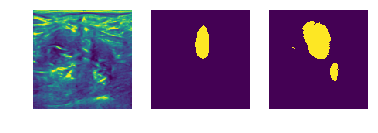

In [10]:
model.eval()

img, targets = test_data[99]

target = targets['main']
inputs = img.unsqueeze(0)
inputs = Variable(inputs)

model=model.cpu()

outputs = model.forward(inputs)
pred = outputs['main']
_, pred = torch.max(pred, 1)
#binary_probs, binary = torch.max(outputs['binary'], 1)

#Comment/Uncomment to enable/disable binary classication
#if binary.data.numpy() == 0:
#    pred = pred * 0
    
pred = pred.squeeze().data.cpu().numpy()
img=np.squeeze(img)
target = target.squeeze().numpy()

fig, ax = plt.subplots(1, 3)
ax[0].imshow(img[0])
ax[0].axis('off')
ax[1].imshow(target)
ax[1].axis('off')
ax[2].imshow(pred)
ax[2].axis('off')
plt.show()

In [24]:
outputs['binary']

Variable containing:
 1.0000e+00  3.5133e-09
[torch.FloatTensor of size 1x2]

#### Are the binary probabilites making sense?
I found it was quite balanced if both values were around 50%. Therefore, train with classweights = [0.25, 0.75] for 5 epochs at least.

In [29]:
outputs['binary']

Variable containing:
 1.0000e+00  3.4286e-11
[torch.FloatTensor of size 1x2]

### Visualize many Images

Set num_example_imgs to whatever you want and modify the slice in test_data[from:to] accordingly.

#### ToDo:
1. Border overlay of mask over image.
2. Filter plots, weights dreaming.
3. ...


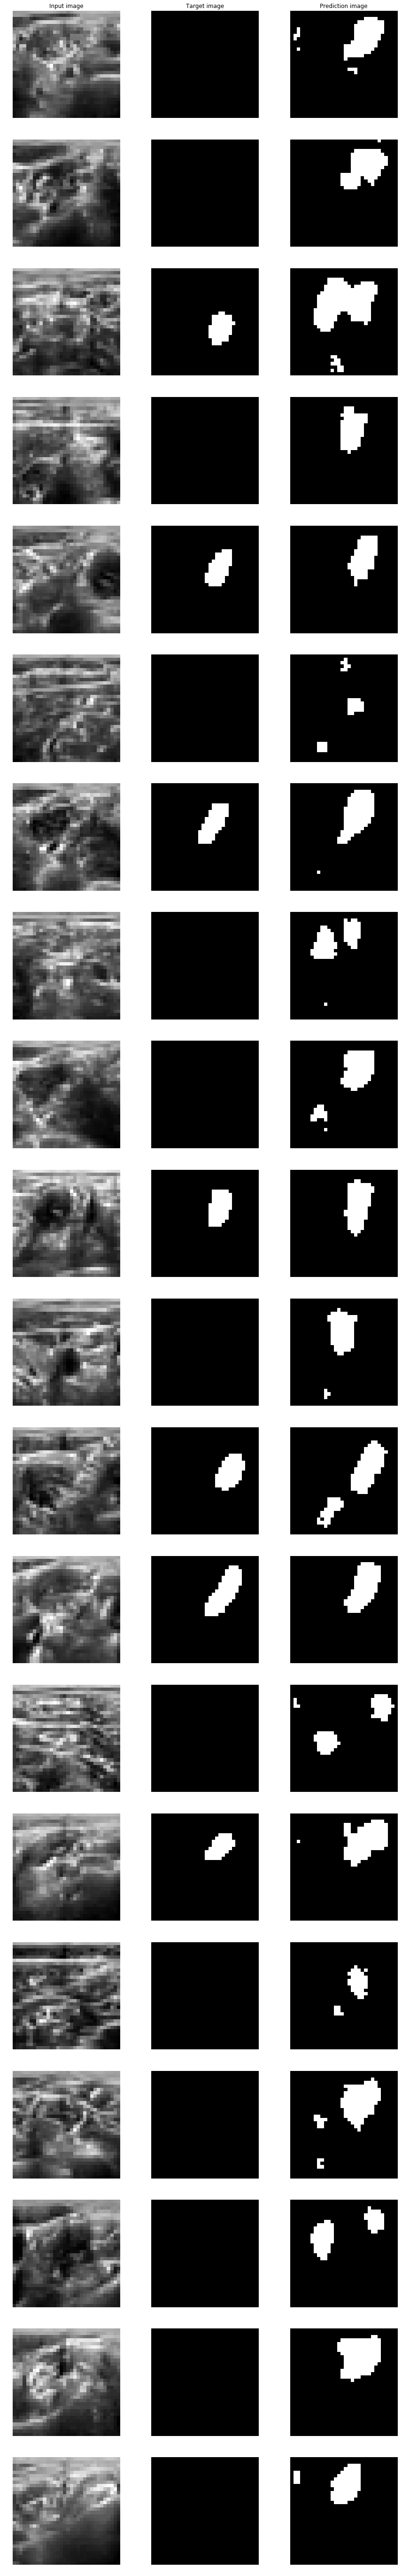

In [25]:
num_example_imgs = 20
plt.figure(figsize=(15, 5 * num_example_imgs))
for i, (img, targets) in enumerate(test_data[20:40]):
    
    target = targets['main']
    inputs = img.unsqueeze(0)
    inputs = Variable(inputs)

    outputs = model.forward(inputs)
    pred = outputs['main']
    _, pred = torch.max(pred, 1)
    #binary_probs, binary = torch.max(outputs['binary'], 1)
    
    #If binary predicts no nerve we just multiply the predicted image with zeros.
    #Comment/Uncomment and plot to compare with/without of binary classification
    #if binary.data.numpy() == 0:
    #    pred = pred * 0
        
    pred = pred.squeeze().data.cpu().numpy()

    img=np.squeeze(img)
    target = target.squeeze().numpy()
        
    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img[0], cmap='gray')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(target, cmap='gray')
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(pred, cmap='gray')
    if i == 0:
        plt.title("Prediction image")
    
plt.show()

### Dice Coefficient on Testdata

In [11]:
def dice_coefficient(ground_truth, predicted):
    gt = ground_truth
    p = predicted
    if np.sum(p) + np.sum(gt) == 0:
        return 1
    else:
        dice = np.sum(p[gt==1])*2.0 / (np.sum(p*p) + np.sum(gt*gt))
        return dice

test_scores = []
model.eval()
for inputs, targets in test_loader:
    inputs, targets = Variable(inputs), Variable(targets['main'])
    if model.is_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
    
    outputs = model.forward(inputs)
    pred = outputs['main']
    _, pred = torch.max(pred, 1)
    #_, binary = torch.max(outputs['binary'], 1)
    
    #Comment/Uncomment to compare with and without binary classification
    #if binary.data.numpy() == 0:
    #    pred = pred * 0
    
    pred = pred.squeeze().data.cpu().numpy()
    test_scores.append(dice_coefficient(np.squeeze(targets.data.numpy()), pred))
    
np.mean(test_scores)

0.09357008391261834

#### Highscore: score and indice of the best predicted image (with nerve).

In [ ]:
x = np.array(test_scores)
x[x==1] = 0
np.max(x), np.argmax(x)

#### Other Stuff
Calculation of ratios in datasets (interesting for balancing class weights)

In [ ]:
#Total ratio of pixels without/with nerve in dataset
N = 0
mask = 0
for _, (img, target) in enumerate(test_data):
    N += target['main'].numel()
    mask += target['main'].sum()
1 - mask/N, mask/N

In [ ]:
#Total ratio of images without/with nerve in dataset
mask = 0
for _, (img, target) in enumerate(test_data):
    mask += target['main'].sum()>0
1 - mask/len(test_data), mask/len(test_data)